# AllLife Bank Customer Segmentation

### Description
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Key Questions
1. What are the key customer segments?
2. How are these segments different from each other?
3. What actions can be recommended to the bank to service each of these segments?

### Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import DistanceMetric

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# ignore warnings
import warnings

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

### Loading the dataset

In [2]:
# loading the dataset
data = pd.read_excel("Credit+Card+Customer+Data.xlsx")

<IPython.core.display.Javascript object>

### Data Overview

In [3]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

In [4]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [5]:
# let's look at the structure of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

In [7]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

##### Observations
1. There are 660 rows and 7 columns.
2. There are no null values in the columns
3. The features are all of integer datatype. 
4. There seems to be outliers in the Avg_Credit_Limit column, and we will need to investigate these values. 
5. Median of the Avg_Credit_Limit column is 18,000, and ranges from 3000 to 200,000. 
6. Interaction parameters like Total_visits_bank, Total_visits_online, Total_calls_made have 0 as minimum values, but they do not seem like null values, but rather valid values which indicate customer has not interacted through the specific channel. 
7. Most customers have atleast 5 credit cards, up to a maximum of 10 cards. 

#### Duplicate rows

In [8]:
# let's check for duplicate observations
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

There are no duplicated rows. Let's verify unique values in each row.

In [9]:
# Check for unique data in each column:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

<IPython.core.display.Javascript object>

##### Observations
1. We do not expect many unique values in most columns like Avg_Credit_Limit and Total_Credit_Cards. However, we had assumed that each row would correspond to a unique customer record, and therefore **Customer Key** was supposed to contain 660 unique records. We would need to investigate to understand why this column has only 655 unique values.

In [10]:
# check for duplicates in Customer Key column
data[data["Customer Key"].duplicated(keep=False)].sort_values("Customer Key")

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


<IPython.core.display.Javascript object>

##### Observation
1. It looks like the same customer was recorded twice in the dataset. There are 5 such customers with duplicate records. 
2. If we look at each customer, we can see that the total credit cards they own are different, the visits / calls they make are different and so on. Therefore it is possible that even though they belong to the same customer, changes have occurred to their profile resulting in the two different record. We can consider these as valid profiles itself. 
3. We will drop the Customer Key column for further analysis, therefore these rows will tend to behave as independent customers.

### EDA

In [11]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

In [12]:
# Let's drop the Sl_No and Customer Key columns
df.drop(columns=["Sl_No", "Customer Key"], axis=1, inplace=True)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

After dropping the columns, there remains only 5 features.

#### Define functions for EDA

In [13]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

In [14]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

### Univariate Analysis

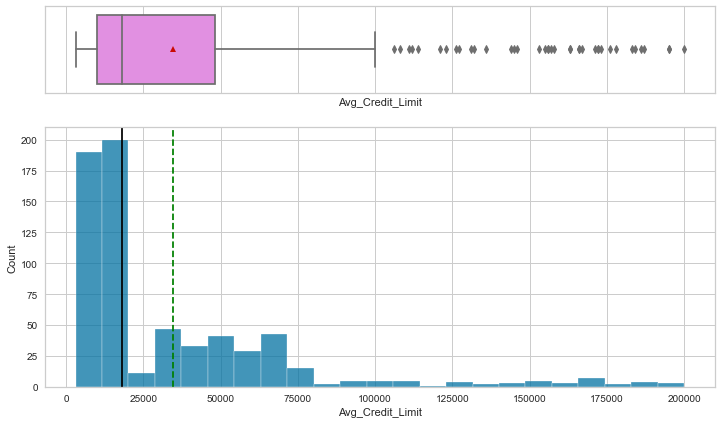

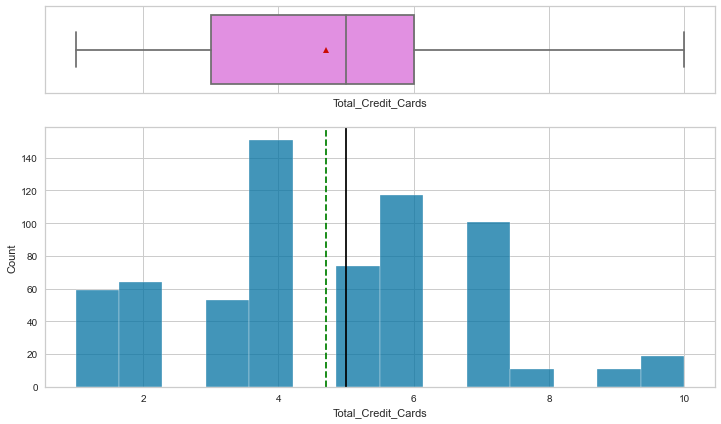

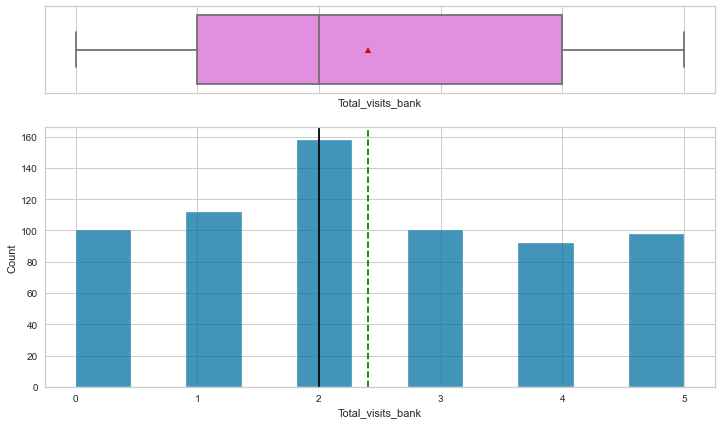

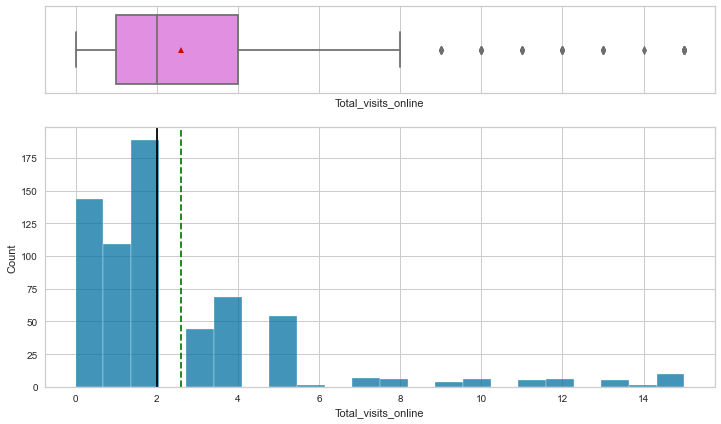

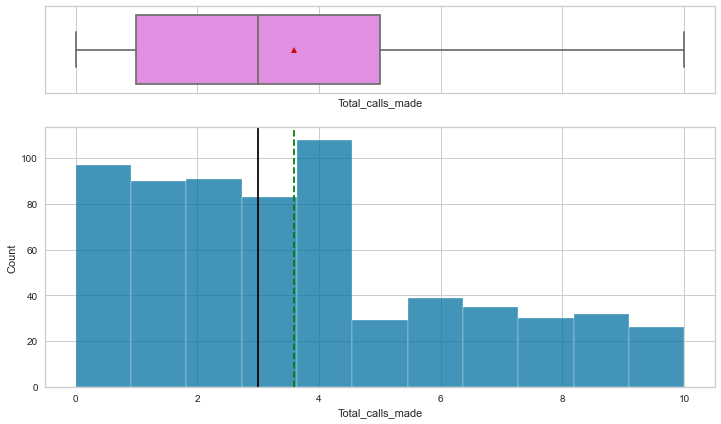

<IPython.core.display.Javascript object>

In [15]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

##### Observations
1. There are outliers in the Avg_Credit_Limit and Total_visits_online columns have outliers. 
2. The median Avg_Credit_Limit is 18000, but outliers are above 100,000. We can look at the credit cards these customers hold and decide whether these are outliers indeed or not. 
3. Median of Total_visits_online is at 2, but outliers lie above 8. These values need not be outliers as banks are encouraging customers to move to their digitized services and as a result, 15 online visits in a year do not seem unlikely. 

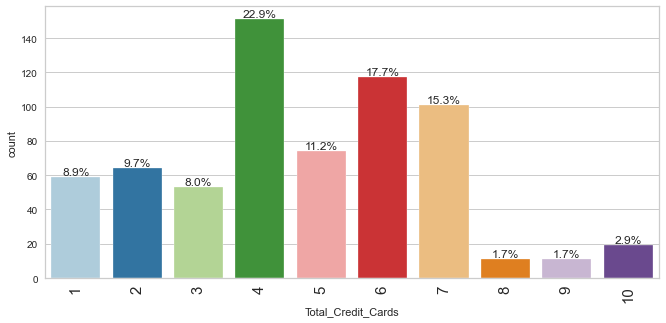

<IPython.core.display.Javascript object>

In [16]:
# let's explore Total_Credit_Cards further
labeled_barplot(df, "Total_Credit_Cards", perc=True)

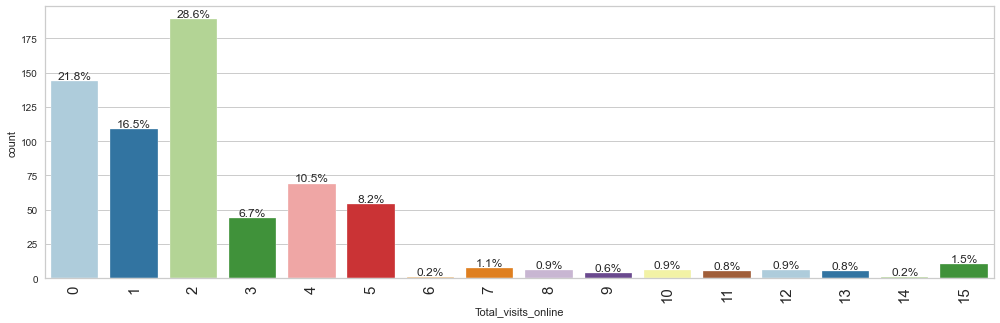

<IPython.core.display.Javascript object>

In [17]:
# let's explore Total_visits_online further
labeled_barplot(df, "Total_visits_online", perc=True)

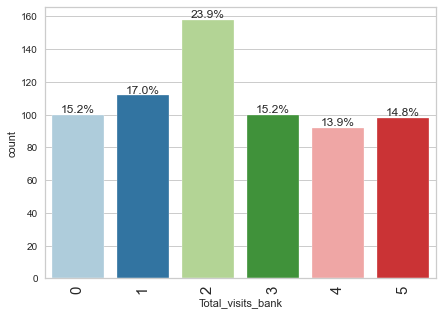

<IPython.core.display.Javascript object>

In [18]:
# let's explore Total_visits_bank further
labeled_barplot(df, "Total_visits_bank", perc=True)

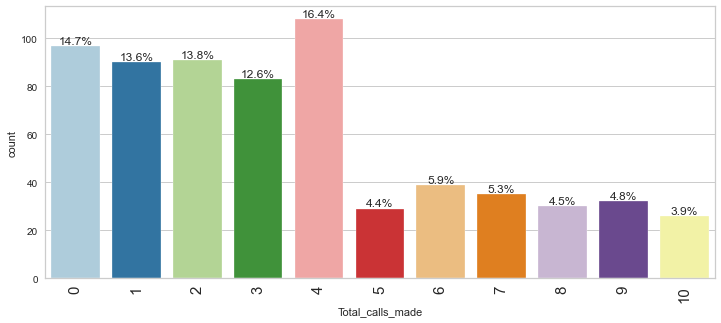

<IPython.core.display.Javascript object>

In [19]:
# let's explore Total_calls_made further
labeled_barplot(df, "Total_calls_made", perc=True)

##### Observations
1. 23% of the customers own 4 cards, and 18% have 6 cards.
2. 29% of the customers make 2 online visits in a year.
3. 24% of the customers make 2 visits to the bank in a year.
4. 17% of the customers make 4 calls to the bank in a year.

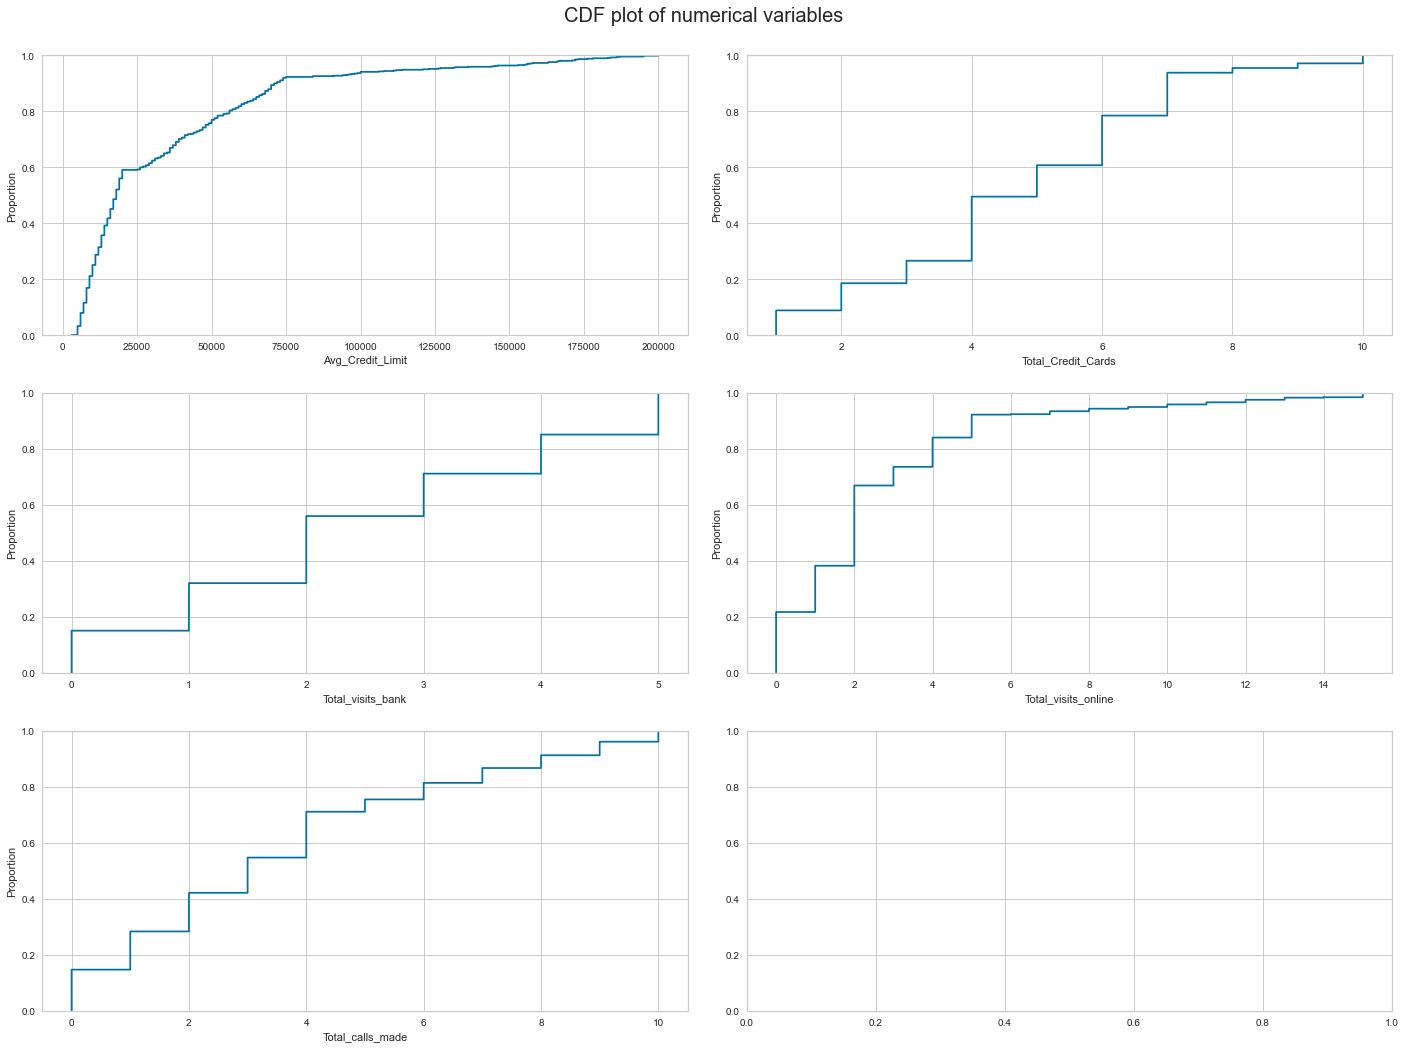

<IPython.core.display.Javascript object>

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

##### Observations
1. 90% of the customers have credit limit below 75000. 
2. 95% of customers have 8 credit cards or less. 
3. 80% of the customers make 4 visits or less to the bank.
4. 90% of the customers make 8 or less online visits. 
5. 90% of the customers make up to 8 calls to the bank in a year.

### Multivariate Analysis

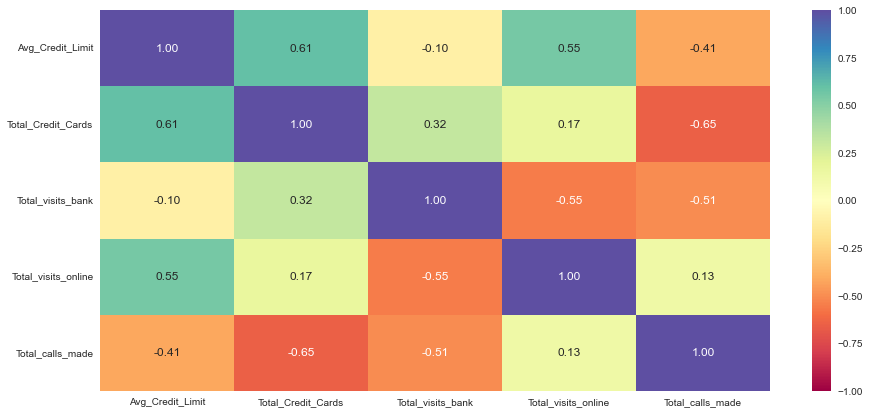

<IPython.core.display.Javascript object>

In [21]:
# plotting a correlation heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

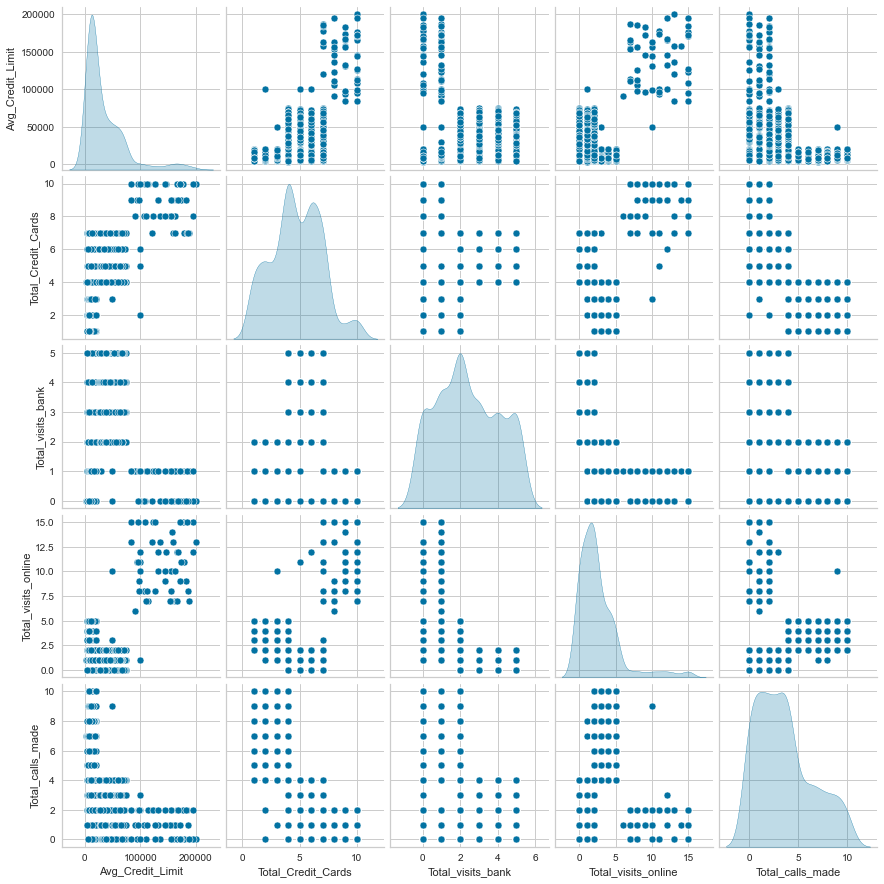

<IPython.core.display.Javascript object>

In [22]:
# plotting a pairplot
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

##### Observations
1. Avg_Credit_Limit is highly correlated with Total_Credit_Cards and Total_visits_online. 
2. Total_calls_made is negatively correlated with Total_Credit_Cards, Avg_Credit_Limit and Total_visits_bank
3. We have the following observations from the pair plots:

From diagonal plots we can see: 
- Total_visits_online has 4-6 points (majorly) 
- Total_calls_made has 2 distinct peaks and several on the tail
- Total_visits_bank has around 6 peaks
- Total_Credit_Cards has 4 distinct peaks

From the scatterplots we can see : - 
- 2 clusters between Avg_Credit_Limit and Total_Credit_Cards 
- 2 clusters between Avg_Credit_Limit and Total_visits_online
- 2 clusters between Total_visits_online and Total_Credit_Cards
- 3 clusters between Total_visits_online and Total_calls_made

#### Products and Interactions

Let's examine the interaction of customers based on the number of credit cards they hold and the average credit limit across the cards they hold. 

In the next section, let's segregate the customers who have a tendency to use only 1 mode of communication as opposed to a mix.

In [23]:
# First let's identify customers who use all 3 modes of communication
all_mode = df[
    (df["Total_calls_made"] != 0)
    & (df["Total_visits_bank"] != 0)
    & (df["Total_visits_online"] != 0)
]
print(
    "We have {}% of customers who use all the 3 support channels".format(
        round(all_mode.shape[0] / df.shape[0] * 100, 2)
    )
)

We have 53.94% of customers who use all the 3 support channels


<IPython.core.display.Javascript object>

In [24]:
# Customers who only use the phone service
phone = data[
    (data["Total_calls_made"] != 0)
    & (data["Total_visits_bank"] == 0)
    & (data["Total_visits_online"] == 0)
]
print("We have {} customers who only use the phone services".format(phone.shape[0]))

We have 0 customers who only use the phone services


<IPython.core.display.Javascript object>

In [25]:
# Customers who only visit the bank as their mode of communication
visit = data[
    (data["Total_calls_made"] == 0)
    & (data["Total_visits_bank"] != 0)
    & (data["Total_visits_online"] == 0)
]
print(
    "We have {} customers who visit the bank as their only mode of communication".format(
        visit.shape[0]
    )
)

We have 30 customers who visit the bank as their only mode of communication


<IPython.core.display.Javascript object>

In [26]:
# Customers who use the online services
online = data[
    (data["Total_calls_made"] == 0)
    & (data["Total_visits_bank"] == 0)
    & (data["Total_visits_online"] != 0)
]
print("We have {} customers who only use the online services".format(online.shape[0]))

We have 7 customers who only use the online services


<IPython.core.display.Javascript object>

In order to find the relationship between products and interactions, let us group Credit Limit into different bins and then see how the other features relate to different levels of limits. Also, for ease of reference let us bin the different interaction features (calls, visits, online) into 5 groups or less. 

In [27]:
# Since the Avg_Credit_Limit column has more than 100 unique values, let us go ahead and group them into bins
df["avg_credit_limit_bins"] = pd.cut(
    df["Avg_Credit_Limit"],
    bins=[3000, 10000, 18000, 48000, 200000],
    labels=["Very Low", "Low", "Medium", "High"],
    include_lowest=True,
)

<IPython.core.display.Javascript object>

In [28]:
# Since the Total_calls_made column has 10 unique values, let us go ahead and group them into bins
df["calls_bins"] = pd.cut(
    df["Total_calls_made"],
    bins=[0, 2, 4, 6, 8, 10],
    labels=["<2", "2-4", "4-6", "6-8", "8-10"],
    include_lowest=True,
)

<IPython.core.display.Javascript object>

In [29]:
# Since the Total_visits_online column has 15 unique values, let us go ahead and group them into bins
df["visits_bins"] = pd.cut(
    df["Total_visits_online"],
    bins=[0, 3, 6, 9, 12, 15],
    labels=["<3", "3-6", "6-9", "9-12", "12-15"],
    include_lowest=True,
)

<IPython.core.display.Javascript object>

In [30]:
# Since the Total_Credit_Cards column has 10 unique values, let us go ahead and group them into bins
df["cards_bins"] = pd.cut(
    df["Total_Credit_Cards"],
    bins=[0, 2, 4, 6, 8, 10],
    labels=["<2", "2-4", "4-6", "6-8", "8-10"],
    include_lowest=True,
)

<IPython.core.display.Javascript object>

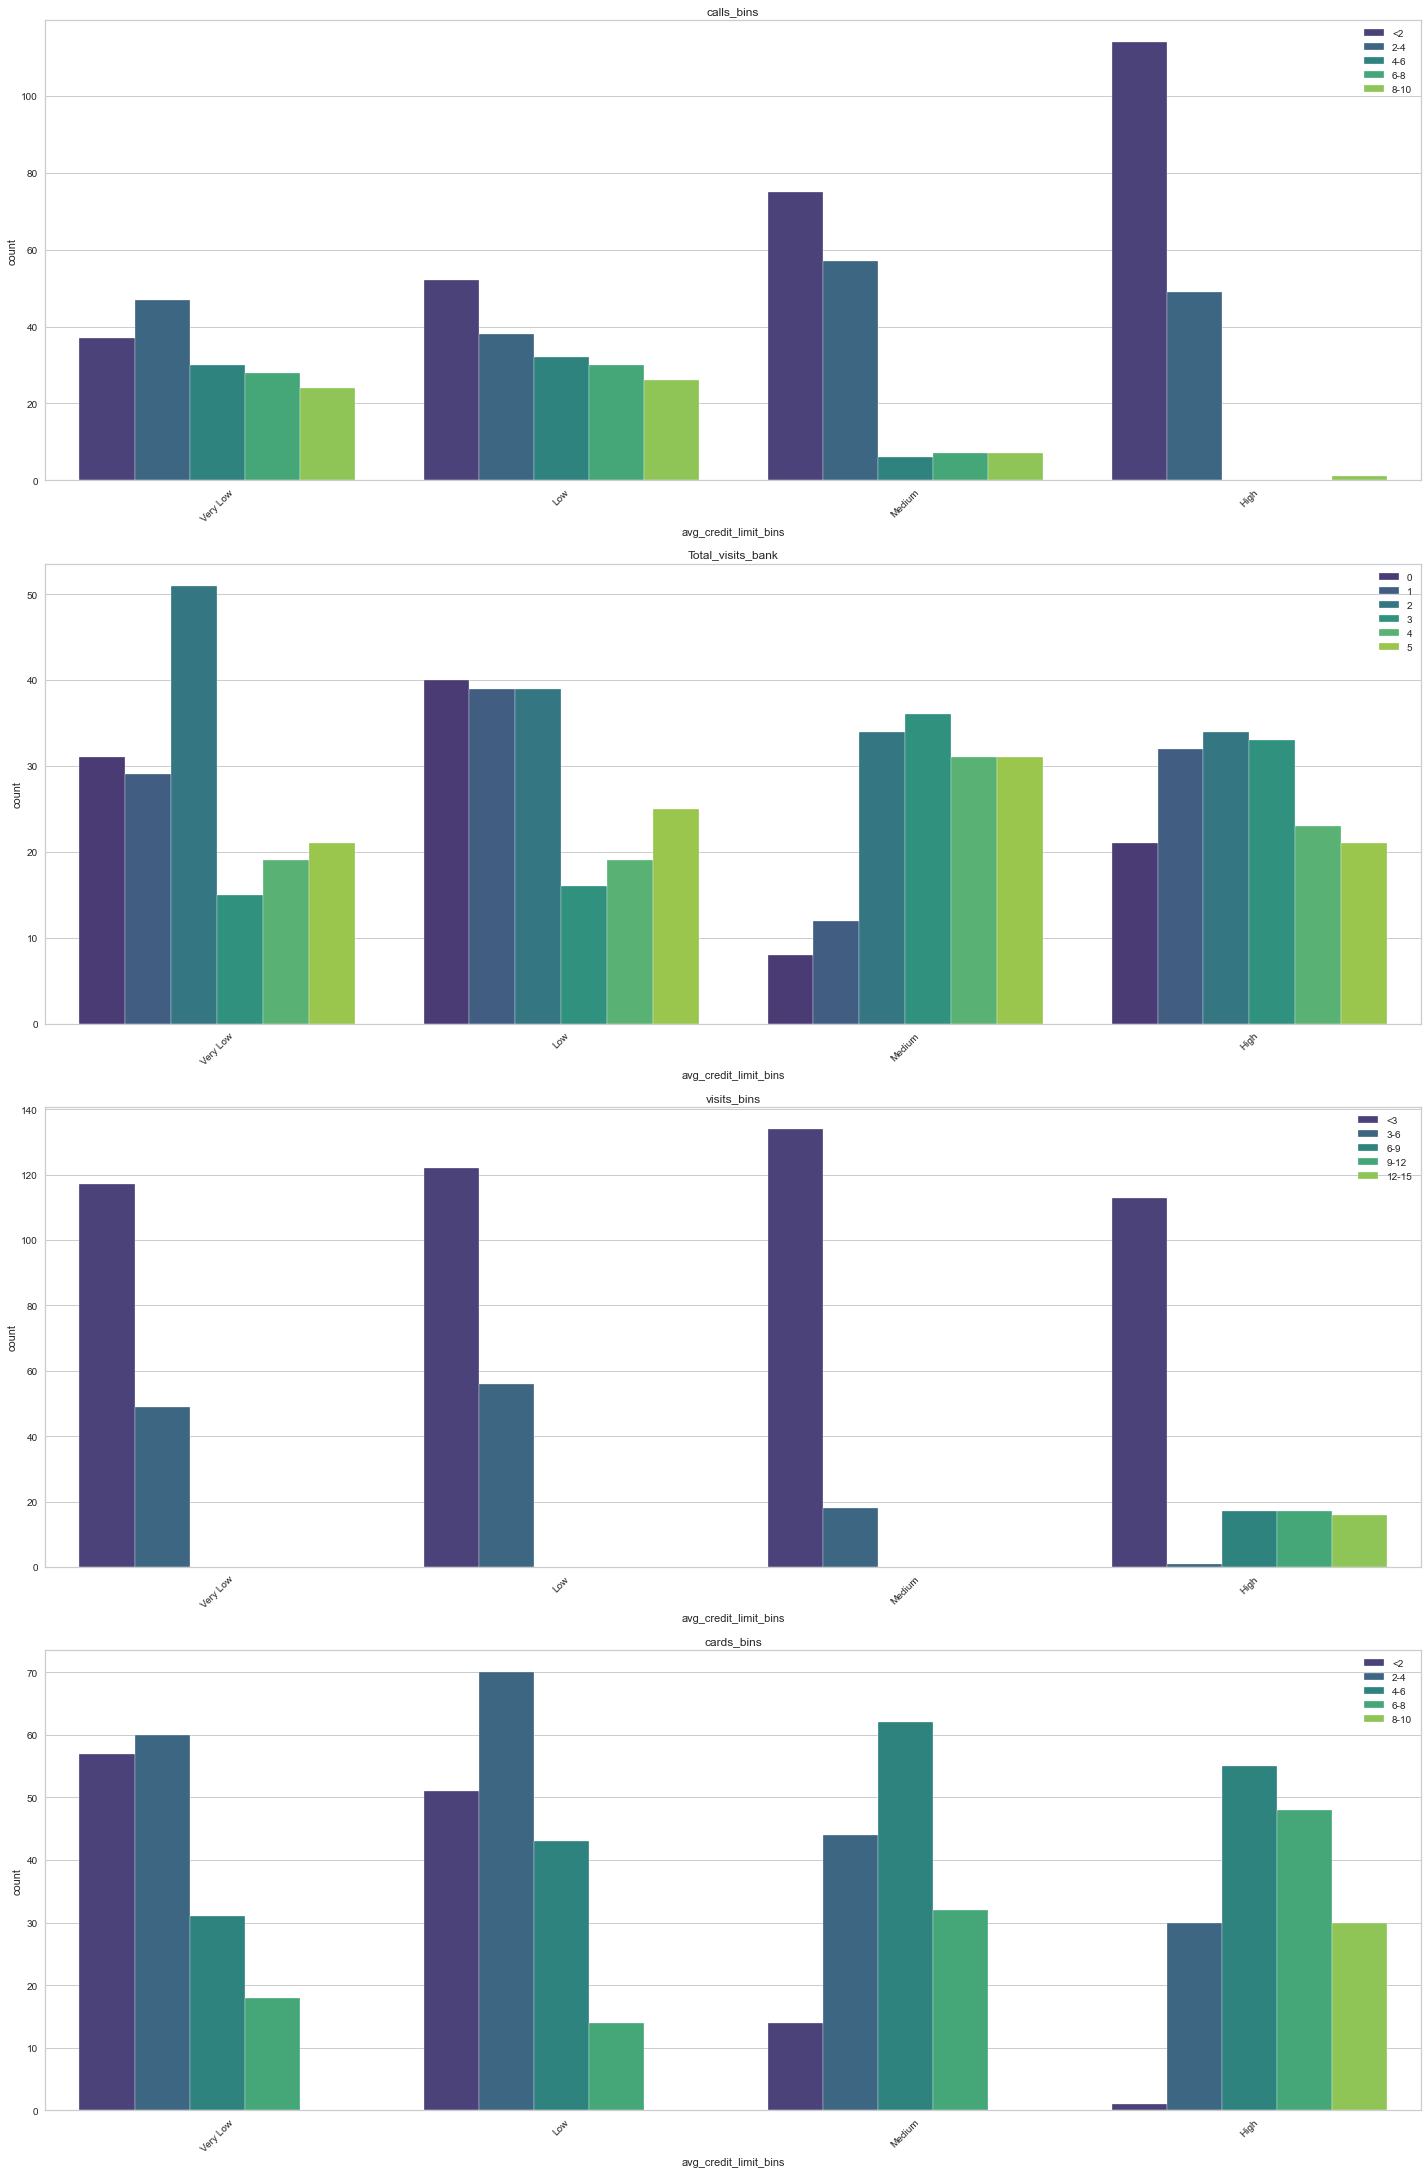

<IPython.core.display.Javascript object>

In [31]:
# define a list of product and interaction features
relationship = [
    "calls_bins",
    "Total_visits_bank",
    "visits_bins",
    "cards_bins",
]

# plot countplots against credit limit bins
plt.figure(figsize=(20, 30))
for i, variable in enumerate(relationship):
    plt.subplot(4, 1, i + 1)
    sns.countplot(
        data=df, hue=df[variable], x="avg_credit_limit_bins", palette="viridis"
    )
    plt.tight_layout()
    plt.title(variable)
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")
plt.show()

##### Observations
1. Almost 50% of the dataset use all channels of communication. 
2. There are only very few customers who strictly use only 1 channel of communication. This means that customers like to engage in atleast two of the channels available to them. 
3. Credit Limit increases with the number of cards the customer holds. 
4. As credit limit increases, the number of calls made to the bank decreases, but online visits tend to increase. 
5. Direct visits to the bank seem to be unaffected by the credit limit.

### Outlier Detection

We have already established there are outliers in Avg_Credit_Limit and Total_visits_online. Let's visit the boxplots again

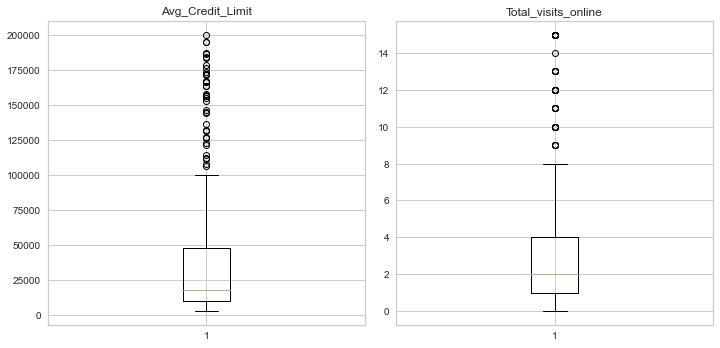

<IPython.core.display.Javascript object>

In [32]:
outlier_col = ["Avg_Credit_Limit", "Total_visits_online"]
plt.figure(figsize=(15, 5))

for i, variable in enumerate(outlier_col):
    plt.subplot(1, 3, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

##### Observations
The values in Total_visits_online need not be outliers as banks these days are encouraging customers to move to their digitized services and as a result, 15 online visits in a year do not seem unlikely. We can treat them as actual valid data.

Let's proceed with verifying the outliers in Avg_Credit_Limit.

In [33]:
# re-intializing the list of outlier columns to contain only the credit limit feature
outlier_col = ["Avg_Credit_Limit"]

<IPython.core.display.Javascript object>

In [34]:
# calculating the Q1 and Q3 values outside of which outliers exist
# this code will print the columns with the number of outliers, and the upper and lower limits of the outliers
for col in outlier_col:
    quartiles = np.quantile(data[col], [0.25, 0.75])
    Q1 = quartiles[0]
    Q3 = quartiles[1]
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = np.logical_or(data[col] < lower, data[col] > upper)
    print(
        "Number of Outliers in", col, "are", outliers.sum(),
    )
    if outliers.sum() > 0:
        if lower > 0:
            print("Outlier values of", col, "are lower than", f"{lower}")
        if upper > 0:
            print("Outlier values of", col, "are greater than", f"{upper}")
    print("\n")

Number of Outliers in Avg_Credit_Limit are 39
Outlier values of Avg_Credit_Limit are greater than 105000.0




<IPython.core.display.Javascript object>

In [35]:
# isolating the outlier rows into a separate dataframe
outlier_df = df[df["Avg_Credit_Limit"] > 105000.0]
outlier_df.shape

(39, 9)

<IPython.core.display.Javascript object>

In [36]:
outlier_df.groupby("Total_Credit_Cards").size()

Total_Credit_Cards
7      7
8     10
9      8
10    14
dtype: int64

<IPython.core.display.Javascript object>

##### Observations
There are 39 rows where Avg_Credit_Limit is high and it happens only for customers who own 7 or more credit cards. Since this value is average of credit limits across all cards, it looks like these values are actually valid and we should proceed without treating. 

### Data Processing

In [37]:
# creating a copy of the original dataframe to use for cluster modelling
df = data.copy()

# creating a copy of the original dataframe for any exercises needed to support modelling
df1 = data.copy()

# dropping columns that are not necessary for cluster analysis
df.drop(columns=["Sl_No", "Customer Key"], axis=1, inplace=True)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [38]:
# isolating the numerical columns for cluster analysis
num_col = df.select_dtypes(include=np.number).columns.tolist()

<IPython.core.display.Javascript object>

### Feature Scaling 

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means and Hierarchical Clustering and is done to avoid the problem of one feature dominating over others. In our case, Avg_Credit_Limit has very high values when compared to the rest of the features, and will tend to dominate in the distance calculations. We will use Standard scaling to ensure that mean of the feature becomes zero, and the resultant distribution has a unit standard deviation.

In [39]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [40]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

### K-means Clustering

##### Elbow method to find optimal k.

Let's use the elbow method to find the optimal k from a range of 2 to 10. We will start with 2, as 2 clusters is the least minimum to begin analysis with. 

Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9426543606899347
Number of Clusters: 7 	Average Distortion: 0.9093991915419353
Number of Clusters: 8 	Average Distortion: 0.8843243844476886
Number of Clusters: 9 	Average Distortion: 0.8650832420580971
Number of Clusters: 10 	Average Distortion: 0.8411372125672628


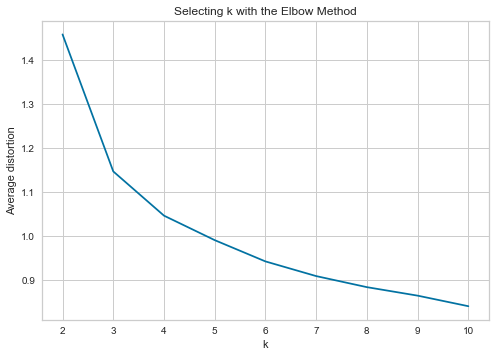

<IPython.core.display.Javascript object>

In [41]:
clusters = range(2, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

##### Observations
The optimal K using elbow method can be either 3 or 4. We can use the silhouette score method to verify the optimal K. 


##### Silhouette score method to find optimal k

Let's find silhouette scores for k between 2 and 10. 

For n_clusters = 3, the silhouette score is 0.5157182558881063
For n_clusters = 2, the silhouette score is 0.41842496663215445
For n_clusters = 4, the silhouette score is 0.3556670619372605
For n_clusters = 5, the silhouette score is 0.2717470361089752
For n_clusters = 6, the silhouette score is 0.255906765297388
For n_clusters = 7, the silhouette score is 0.24798644656011146
For n_clusters = 8, the silhouette score is 0.2414240144760896
For n_clusters = 9, the silhouette score is 0.2184645050755029
For n_clusters = 10, the silhouette score is 0.21406586730833518


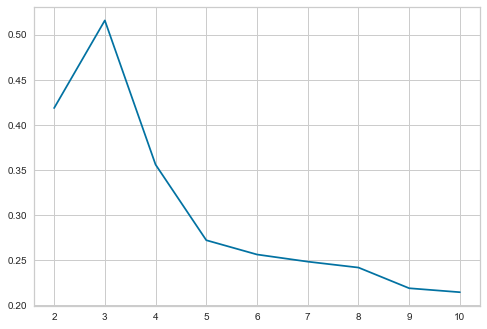

<IPython.core.display.Javascript object>

In [42]:
sil_score = []
cluster_list = list(range(2, 11))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)

sil_score_sorted = sorted(sil_score, reverse=True)

for score in sil_score_sorted:
    index = sil_score.index(score)
    print(
        "For n_clusters = {}, the silhouette score is {}".format(
            cluster_list[index], score
        )
    )


plt.plot(cluster_list, sil_score)
plt.show()

##### Observations

The highest silhouette score is at 3. The score at 4 has dropped, and we need not use 4 as an optimal k. But we can verify this again with the silhouette visualizer functions.

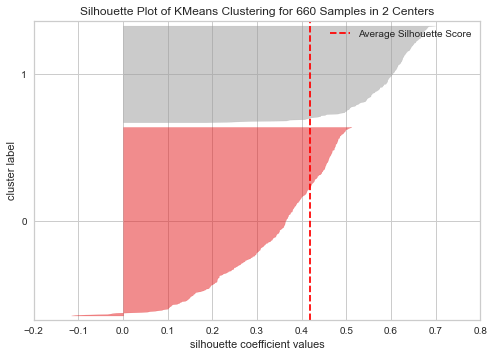

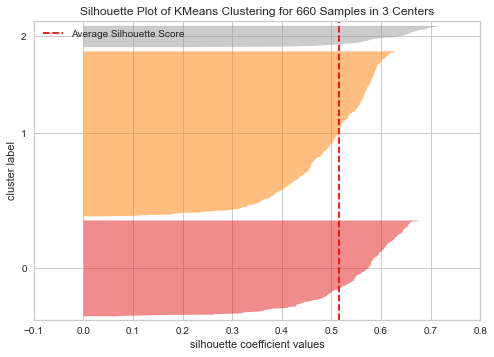

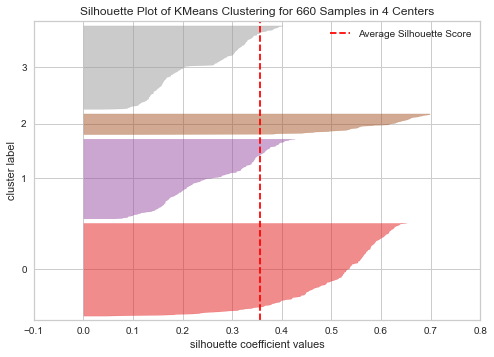

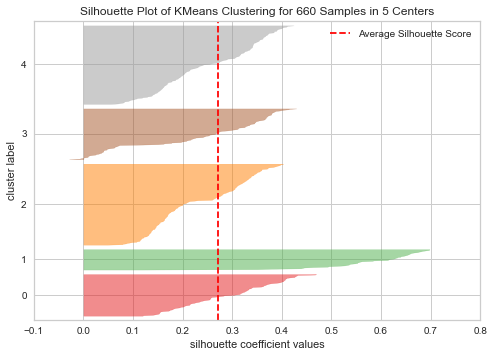

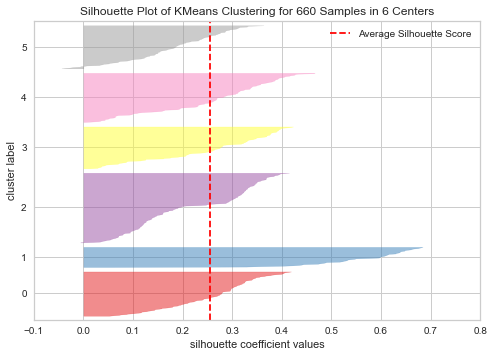

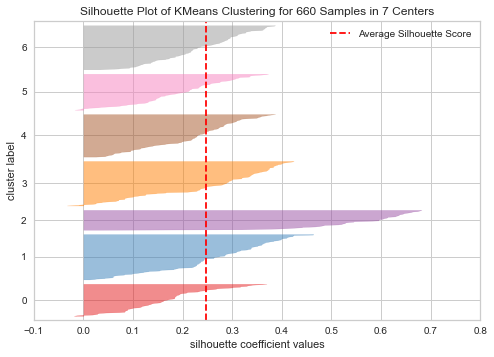

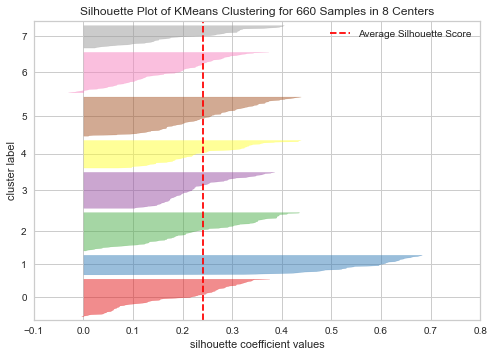

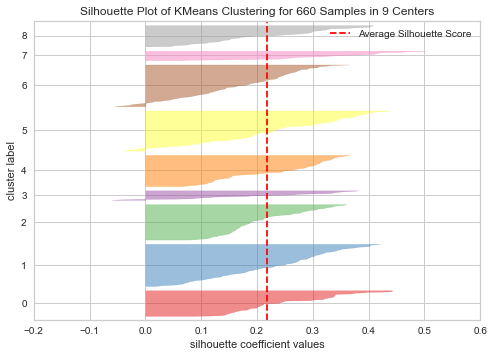

<IPython.core.display.Javascript object>

In [43]:
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    visualizer = SilhouetteVisualizer(KMeans(n_clusters, random_state=1))
    visualizer.fit(subset_scaled_df)
    visualizer.show()

##### Observations

k=2: Cluster 0 has negative coefficient values and the average silhouette coefficient value is ~0.45.

k=3: All the 3 clusters have above average silhouette coefficient values and none of them have negative coefficient values. The average silhouette coefficient value is ~0.52, the best across all possible values of k. The 3 clusters have different widths and each of them have different silhouette scores.

k=4-9 : These clusters have very a low coefficient value and most of them have negative coefficients as well. We cannot consider them as ideal clusters

##### Let's take k=3 as the optimal value of clusters

In [44]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=1)

<IPython.core.display.Javascript object>

In [45]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_
df1["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [46]:
cluster_profile = df.groupby("K_means_segments").median()

<IPython.core.display.Javascript object>

In [47]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [48]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,12000.000000,2.000000,1.000000,4.000000,7.000000,224
1,31000.000000,6.000000,3.000000,1.000000,2.000000,386
2,145500.000000,9.000000,1.000000,11.000000,1.000000,50


<IPython.core.display.Javascript object>

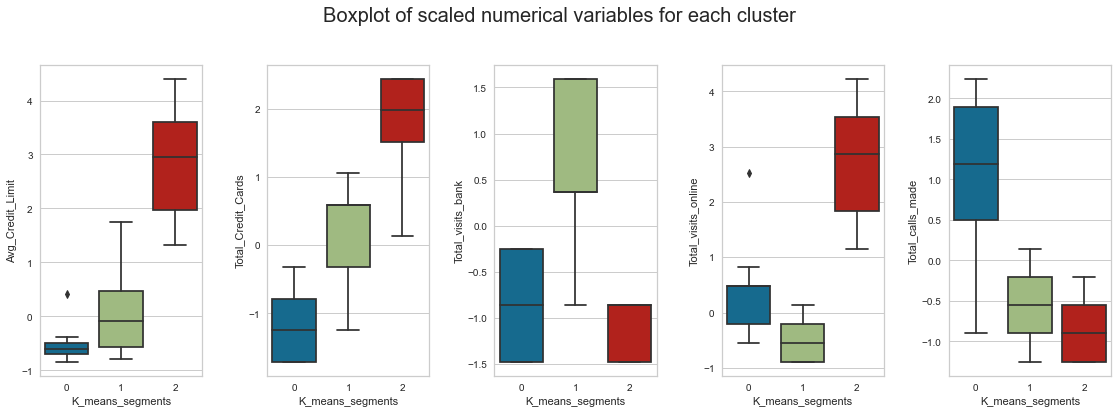

<IPython.core.display.Javascript object>

In [49]:
# boxplots of scaled data set
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

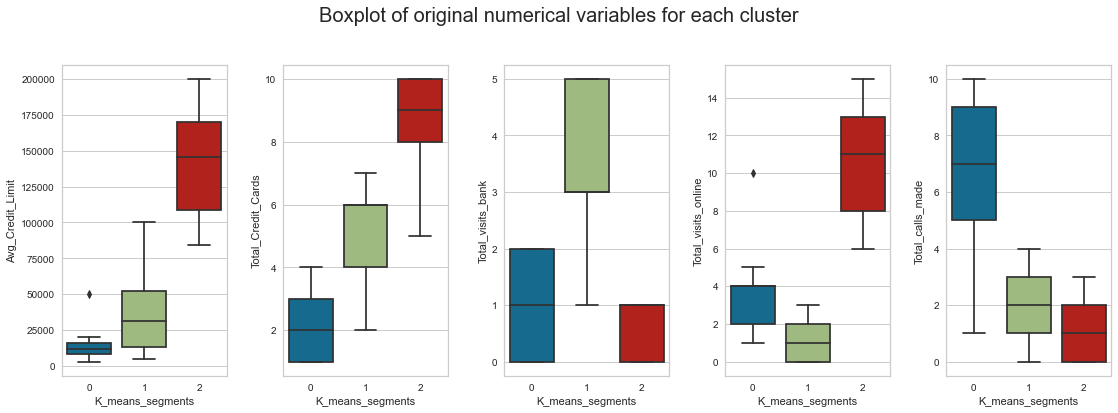

<IPython.core.display.Javascript object>

In [50]:
# boxplots of original data
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Cluster Insights

**Cluster 0:** These customers have a median credit limit of 12500, maximum of 4 cards. They are likely to make upto 2 visits per year to the bank, 2-4 visits online. They are most likely to interact mostly through direct calls to the bank. 

**Cluster 1:** Their median credit limit lies around 30,000. Most of these customers are likely to contact the banks by directly visiting them, than by online channels or direct calls. They are likely to own 2-7 credit cards, and therefore their credit limit can range from 10,000 to 100,000. 

**Cluster 2:** These customers have a higher number of credit cards, from 5 to 10, and therefore their credit limit also tends to be on the higher side, from 90,000 to 200,000. They are likely to engage with the bank through online channels, atleast 6 to 15 times in a year, followed by direct calls and visits. 

### Hierarchical Clustering

Let us perform hierarchical clustering on the dataset and see what clusters we can obtain. 

In [51]:
# creating a copy of the original dataframe for modelling
df = data.copy()

# creating a copy of the original dataframe for any exercises needed to support modelling
df1 = data.copy()

# dropping columns that are not necessary for cluster analysis from the dataset for modelling
df.drop(columns=["Sl_No", "Customer Key"], axis=1, inplace=True)

# verifying the dataset for modelling
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [52]:
# isolating the numerical columns for cluster analysis
num_col = df.select_dtypes(include=np.number).columns.tolist()

<IPython.core.display.Javascript object>

In [53]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [54]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

#### Cophenetic Correlations

Let us try out different distance metrics and linkage mechanisms and identify which of these combinations would give us the highest cophenetic correlation. The combination that gives the highest cophenetic correlation would indicate the dendrogram that most faithfully preserves the pairwise distances between the original unmodeled data points.

In [55]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm,)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

<IPython.core.display.Javascript object>

In [56]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

##### Observation
1. The highest cophenetic correlation is obtained for the dendrogram with Euclidean distance and average linkage. 

We can still compare the dendrograms obtained from Euclidean distances and the different linkages. 

In [57]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    # using only the euclidean distance to measure distances
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [58]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

##### Observation
1. The dendrograms with weighted, complete and average linkage show much promise with correlation scores of 85% and above.
2. The dendrogram with average linkage has the highest cophenetic correlation score. 

Let us plot the actual dendrograms

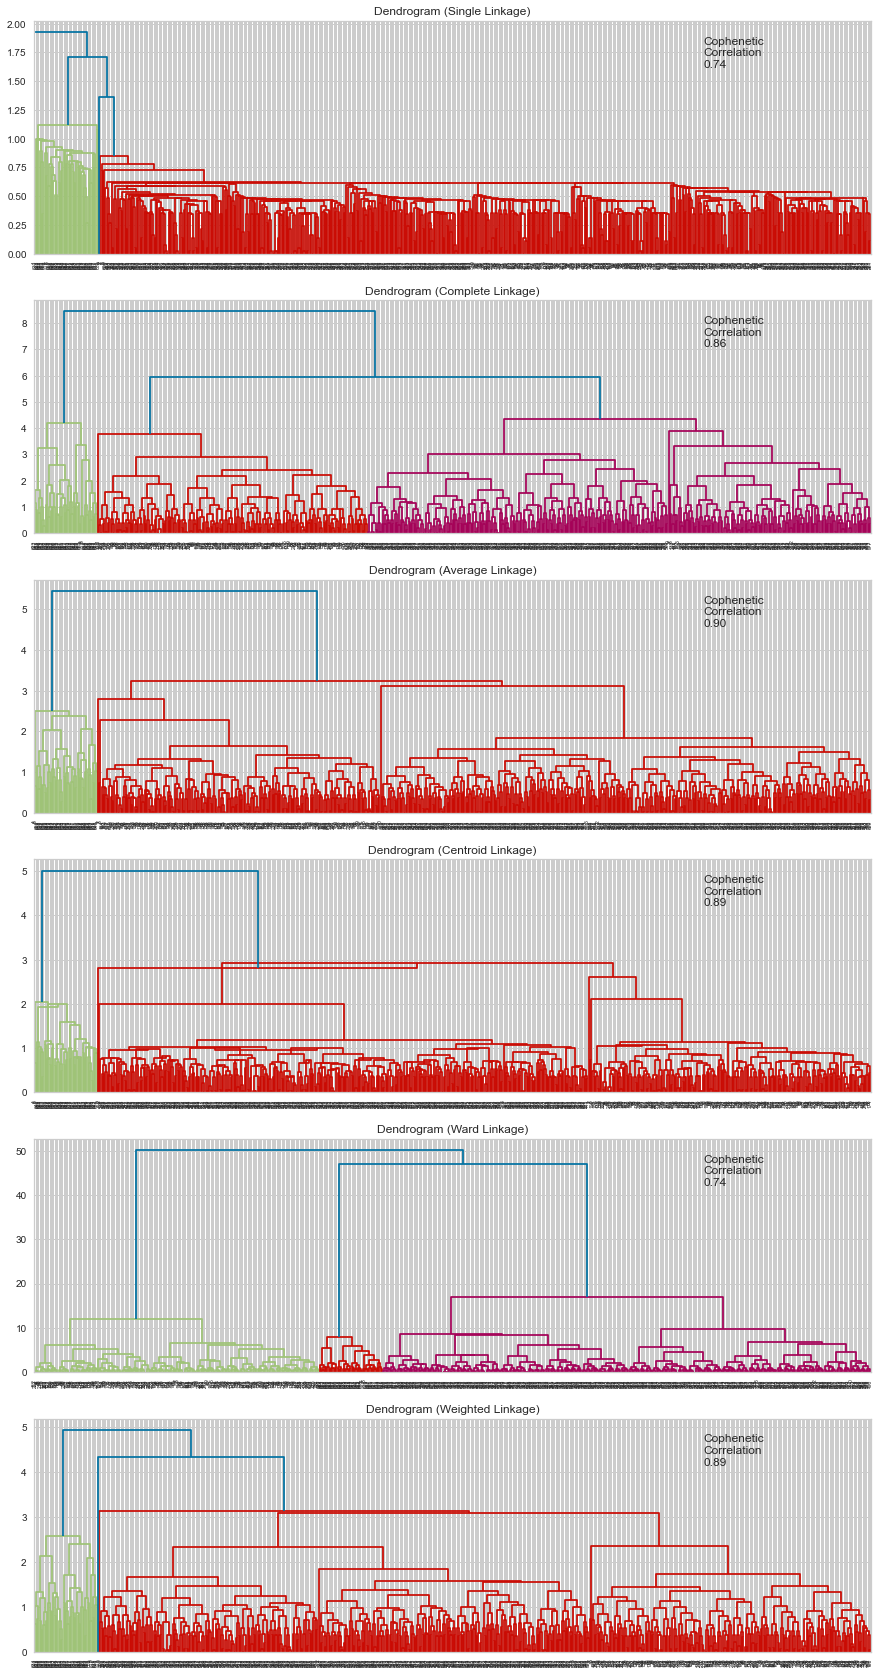

<IPython.core.display.Javascript object>

In [59]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

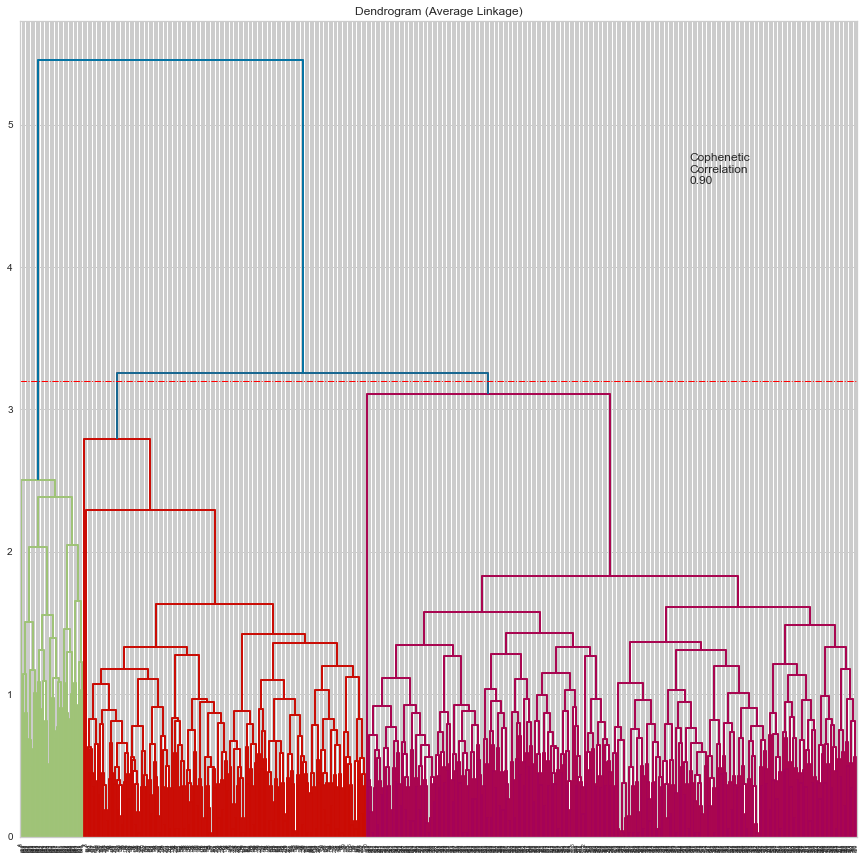

<IPython.core.display.Javascript object>

In [60]:
# list of linkage methods
linkage_methods = ["average"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=3.2)
plt.axhline(y=3.2, c="red", lw=1, linestyle="dashdot")

##### Observations
As we can see, the dendrogram with Euclidean distance and average linkage gives us atleast three distinct clusters. 

If we go by conventional methods of identifying the appropriate number of clusters, ie, by cutting through the vertical line with the maximum length, then the ideal number of clusters would be 2. However, we are not choosing this for the two reasons below:
1. It is very clear from the dendrogram that there are three distinct clusters. 
2. Grouping the customers of a bank into just 2 clusters would not be beneficial to a bank. Even when we profile on layman terms, without using any mathematical algorithms, customers of a bank can be profiled atleast into three broad categories, be it on the basis of income or economic status or credit limit or others. These could be, say, High Income, Moderate Income and Low Income customers. Or High class, middle class and low class. Therefore, it only makes sense to have clusters of 3 than only 2. 


Let's verify the optimal number of clusters using the silhouette score method

For n_clusters = 2, the silhouette score is 0.5703183487340514
For n_clusters = 3, the silhouette score is 0.515922432650965
For n_clusters = 4, the silhouette score is 0.47495143595793504
For n_clusters = 5, the silhouette score is 0.44039753024783956
For n_clusters = 7, the silhouette score is 0.41837756746720256
For n_clusters = 6, the silhouette score is 0.4153547954831452
For n_clusters = 10, the silhouette score is 0.34550947121387965
For n_clusters = 8, the silhouette score is 0.34306710358280806
For n_clusters = 9, the silhouette score is 0.34154869328908927


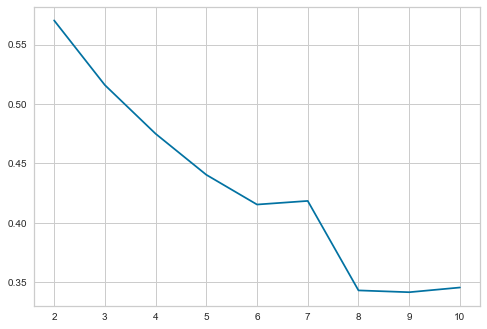

<IPython.core.display.Javascript object>

In [61]:
sil_score = []
cluster_list = list(range(2, 11))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="average"
    )
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)

sil_score_sorted = sorted(sil_score, reverse=True)

for score in sil_score_sorted:
    index = sil_score.index(score)
    print(
        "For n_clusters = {}, the silhouette score is {}".format(
            cluster_list[index], score
        )
    )


plt.plot(cluster_list, sil_score)
plt.show()

##### Observations
From the silhouette score, we understand that 2 is the optimal number of cluster. However, for the same reasoning that we provided above, we will chose 3 as the optimal number, which also has the next best score.

Let's fit the selected cluster model on the data and label the data into clusters. 

In [62]:
# fitting the cluster model
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [63]:
# assigning the labels from the model to the original and scaled dataset
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_
df1["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

In [64]:
# let's display cluster profiles
cluster_profile = df.groupby("HC_Clusters").median()
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Total_Credit_Cards"].count().values
)

cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,31000.000000,6.000000,3.000000,1.000000,2.000000,387
1,145500.000000,9.000000,1.000000,11.000000,1.000000,50
2,12000.000000,2.000000,1.000000,4.000000,7.000000,223


<IPython.core.display.Javascript object>

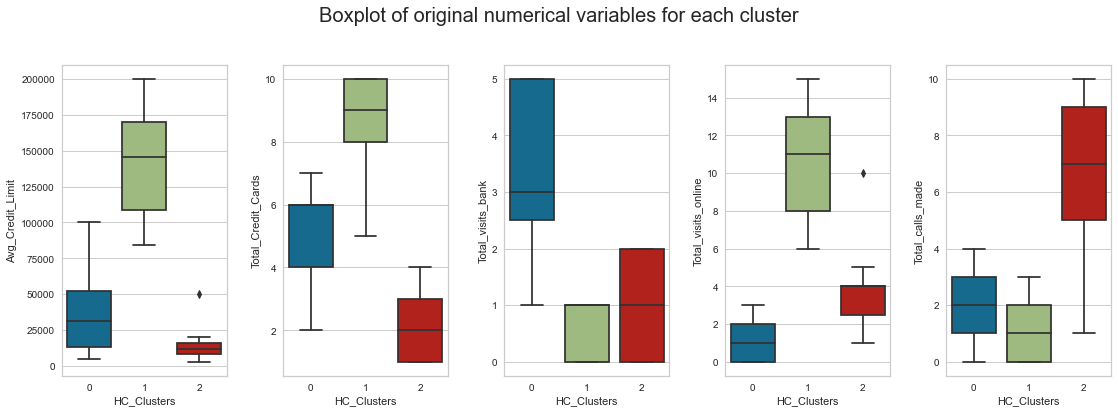

<IPython.core.display.Javascript object>

In [65]:
# boxplots of original data
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

##### Observations
**Cluster 0**: There are 387 customers in this cluster. Their median credit limit lies around 30,000. Most of these customers are likely to contact the banks by directly visiting them, than by online channels or direct calls. They are likely to own 2-7 credit cards, and therefore their credit limit can range from 10,000 to 100,000. This cluster corresponds to Cluster 1 we obtained from K-means methods.

**Cluster 1**: There are only 50 customers in this cluster. These customers have a higher number of credit cards, from 5 to 10, and therefore their credit limit also tends to be on the higher side, from 90,000 to 200,000. They are likely to engage with the bank through online channels, atleast 6 to 15 times in a year, followed by direct calls and visits.This cluster corresponds to Cluster 2 we obtained from K-means methods.


**Cluster 2**: There are 223 customers in this cluster. These customers have a median credit limit of 12000, maximum of 4 cards. They are likely to make upto 2 visits per year to the bank, 1-5 visits online. They are most likely to interact mostly through direct calls to the bank, maybe upto 10 times a year.This cluster corresponds to Cluster 0 we obtained from K-means methods.

#### Analysing the duplicate records

Since we received almost similar clusters from both k-means and hierarchical clustering, let's use the clusters from Hierarchical clustering to analyse the duplicated records we found during data processing. 

In [66]:
# let's use the dataframe we kept aside for exercises
df1[
    df1["Customer Key"].isin(
        df1[df1["Customer Key"].duplicated()]["Customer Key"].tolist()
    )
].sort_values("Customer Key")

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters
48,49,37252,6000,4,0,2,8,2
432,433,37252,59000,6,2,1,2,0
4,5,47437,100000,6,0,12,3,1
332,333,47437,17000,7,3,1,0,0
411,412,50706,44000,4,5,0,2,0
541,542,50706,60000,7,5,2,2,0
391,392,96929,13000,4,5,0,0,0
398,399,96929,67000,6,2,2,2,0
104,105,97935,17000,2,1,2,10,2
632,633,97935,187000,7,1,7,0,1


<IPython.core.display.Javascript object>

##### Observations
Three of these customers, (Customer Keys = 37252, 47437 and 97935) have changed clusters during the time this data was collected. In all three cases, there has been an increase in credit limit of these customers. Customer interaction also has changed, but there is no consistent pattern. It is possible that increasing the credit limit can convert the customer to a more profitable cluster. 

### Summary and Conclusions

### Summary of Data

1. There were 660 rows and 7 columns.
2. There are no null values in the columns and all features were of integer datatype.

### Assumptions
1. Key customer demographics like Age, Income, Occupation are not captured in the dataset. Knowing this information can be crucial in treating outliers and creating more meaningful clusters. 
2. All customers had equal access to interaction channels like call, online and direct visits, and were not forced to choose a channel because they did not have access to another. 

### Summary of Data Treatments
1. The column Sl_No was dropped for both EDA and cluster modelling. 
2. Duplicates were found in the Customer Key column, but it seemed that the duplicated records were distinct in all other aspects of data, hence they were retained as valid profiles. (After clustering, we found that these customers changed clusters due to changes in their parameters.) 
3. Customer Key column was dropped for both EDA and cluster modelling.
4. After these treatments, the dataset was left with 5 features for EDA and modelling. 

### Key Observations from EDA
- Avg_Credit_Limit is highly correlated with Total_Credit_Cards and Total_visits_online.
- Total_calls_made is negatively correlated with Total_Credit_Cards, Avg_Credit_Limit and Total_visits_bank
- 23% of the customers own 4 cards, and 18% have 6 cards.
- 29% of the customers make 2 online visits in a year.
- 24% of the customers make 2 visits to the bank in a year.
- 17% of the customers make 4 calls to the bank in a year.
- 90% of the customers have credit limit below 75000.
- 95% of customers have 8 credit cards or less.
- 80% of the customers make 4 visits or less to the bank.
- 90% of the customers make 8 or less online visits.
- 90% of the customers make up to 8 calls to the bank in a year.
- Almost 50% of the dataset use all channels of communication.
- There are only very few customers who strictly use only 1 channel of communication. This means that customers like to engage in atleast two of the channels available to them.
- Credit Limit increases with the number of cards the customer holds.
- As credit limit increases, the number of calls made to the bank decreases, but online visits tend to increase.
- Direct visits to the bank seem to be unaffected by the credit limit.

### Data Preparation

**Feature Engineering**
- The columns Sl_No and Customer Key were dropped as they did not contribute any power to cluster modelling. 

**Feature Scaling**
- The column Avg_Credit_Limit has very high values when compared to the other columns. This column would dominate in distance measurements, resulting in unreliable predictions. Therefore all columns were scaled using standard scaling to ensure that mean of the feature becomes zero, and the resultant distribution has a unit standard deviation. 

**Outlier Treatments**
- There were outliers in the Avg_Credit_Limit and Total_visits_online columns have outliers.
- The outliers in Avg_Credit_Limit are above 100,000 but they appear only for customers who own 7 or more credit cards. Since this value is average of credit limits across all cards, these values are actually valid and they were not treated.
- The outliers in Total_visits_online lie above 8. These values are not outliers as banks these days are encouraging customers to move to their digitized services and as a result, 15 online visits in a year do not seem unlikely.

### Summary of cluster analysis

We have performed both k-means clustering and hierarchical clustering. 

**K-Means Clustering**:

- We tried to find optimal clusters using both Elbow Method and Silhouette Scores. 
- Both methods returned 3 as the optimal k. 

**Hierarchical Clustering**:
- We tried to find optimal clusters using different distance metrics and linkage techniques. 
- Eventually the Euclidean distance with average linkage offered the best Cophenetic Correlation score. 
- From the dendrogram plot, 3 distinct clusters were identified. 

Both K-Means and Hierarchical Clustering returned clusters that were almost identical in nature and numbers, and their summary is provided below. Since this is a small dataset, with 660 records and 5 distinct features, both k-means and hierarchical clustering are ideal clustering model candidates.

### Cluster Summary

**Cluster 0**: There are 387 customers in this cluster. Their median credit limit lies around 30,000. Most of these customers are likely to contact the banks by directly visiting them, than by online channels or direct calls. They are likely to own 2-7 credit cards, and therefore their credit limit can range from 10,000 to 100,000. 

**Cluster 1**: There are only 50 customers in this cluster. These customers have a higher number of credit cards, from 5 to 10, and therefore their credit limit also tends to be on the higher side, from 90,000 to 200,000. They are likely to engage with the bank through online channels, atleast 6 to 15 times in a year, followed by direct calls and visits.

**Cluster 2**: There are 223 customers in this cluster. These customers have a median credit limit of 12000, maximum of 4 cards. They are likely to make upto 2 visits per year to the bank, 1-5 visits online. They are most likely to interact mostly through direct calls to the bank, maybe upto 10 times a year.

### Actionable Insights and Recommendations

From the cluster analysis, we have seen there are three distinct clusters.

- The first cluster is the one with most customers, owning 2-7 credit cards and credit limit from 10,000 to 100,000. They engage with the bank by directly, rather than by online channels or direct calls. These could be people in the middle strata of economic hierarchy, i.e., middle class, moderate income section of the population. These customers look for value for money deals, so attract them with cashback offers on credit card purchases, etc. Judging by the number of times they interact with the bank on an annual basis (very few number of times), it is possible that these customers are either not financially aware of different growth instruments and are also possibly risk-averse. Since they are the largest cluster, banks should study them carefully before offering best fit solutions. 

- The second cluster is the next highest, however they do not show much financial promise because their highest average credit limit is less than 25,000. They also hold only upto 4 cards. However, these customers are more likely to interact through the digital channels. All of these characteristics point towards younger customers who have just embarked on their spending journey, for example, students and newly employed. This cluster has much potential to be converted into one of the two clusters as their life situation changes. Monitor these clusters and maintain regular relationships and offer them packages that can convert them. 

- The final cluster is the one with very few customers, but with the highest financial promise. These customers have most cards, upto 10 and average credit limit ranges from 90,000 to 200,000. Invest in relationship managers for these clusters, and engage them with meaningful investment advices. We have also seen that with higher credit limit, there is a tendency to use online services more. Therefore, invest more on digital front-ends and build self-service capabilities for these customers. 

On analysing the duplicated customer records, we also found that these are customers who changed their cluster during the year and this change is associated with an increase in credit limit of these customers. We know that the more credit cards a customer owns, the credit limit tends to increase. Therefore offering additional credit cards is possibly a way to convert customers to profitable clusters. However, this hypothesis must be carefully surveyed with more customer samples and a conclusion reached only after that.  

Apart from this, the bank can also capture meaningful demographic information about their customers and use it alongside to build even more meaningful relationships. It would also make sense to capture data about customers' interaction with the bank and their satisfaction about different products. This will help to predict which products they can be offered based on their interests.